In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
os.listdir()

['.ipynb_checkpoints', 'FaceReg.ipynb', 'facereg.keras', 'test.jpg']

In [15]:
# Load model
model_path = 'facereg.keras'
model = load_model(model_path)
 
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 21,695,039 (82.76 MB)

 Trainable params: 6,599 (25.78 KB)

 Non-trainable params: 21,675,240 (82.68 MB)

 Optimizer params: 13,200 (51.57 KB)

In [6]:
print(model.input_shape)

(None, 128, 128, 3)


In [7]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh từ {img_path}")
    
    # Chuyển sang grayscale để phát hiện khuôn mặt
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sử dụng Haar cascade để phát hiện khuôn mặt
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    if len(faces) == 0:
        # Thử cascade khác nếu không phát hiện được
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    if len(faces) == 0:
        print("Cảnh báo: Không phát hiện khuôn mặt rõ ràng, sẽ xử lý toàn bộ ảnh")
        face = cv2.resize(img, (128, 128))  # Thay đổi từ 224x224 thành 128x128
        face = face.astype('float32') / 255.0
        return np.expand_dims(face, axis=0), (0, 0, img.shape[1], img.shape[0])
    
    # Lấy khuôn mặt đầu tiên
    (x, y, w, h) = faces[0]
    face = img[y:y+h, x:x+w]
    
    # Resize về 128x128
    face = cv2.resize(face, (128, 128))
    
    # Chuẩn hóa pixel values
    face = face.astype('float32') / 255.0
    
    # Thêm batch dimension
    face = np.expand_dims(face, axis=0)
    
    return face, (x, y, w, h)

In [8]:
def predict_demographics(img_path):
    # Tiền xử lý ảnh
    face, (x, y, w, h) = preprocess_image(img_path)
    
    predictions = model.predict(face)
    
    # Giả sử model trả về 3 outputs: age, gender, race
    age = predictions[0][0] * 100  # Giả sử tuổi được chuẩn hóa về [0,1]
    gender_prob = predictions[1][0]
    race_prob = predictions[2][0]
    
    # Xác định giới tính
    gender = "Nữ" if gender_prob[0] > 0.5 else "Nam"
    gender_confidence = max(gender_prob[0], 1 - gender_prob[0])
    
    # Xác định sắc tộc
    race_classes = ['White', 'Black', 'Asian', 'Indian', 'Others']
    race_idx = np.argmax(race_prob)
    race = race_classes[race_idx]
    race_confidence = race_prob[race_idx]
    
    return {
        'age': int(age),
        'gender': gender,
        'gender_confidence': float(gender_confidence),
        'race': race,
        'race_confidence': float(race_confidence),
        'face_coordinates': (int(x), int(y), int(w), int(h))
    }

In [9]:
def display_results(img_path, results):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x, y, w, h = results['face_coordinates']
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    info = f"Age: {results['age']}\nGender: {results['gender']} ({results['gender_confidence']:.2f})\nRace: {results['race']} ({results['race_confidence']:.2f})"
    
    y_text = y - 10 if y - 10 > 10 else y + h + 20
    for i, line in enumerate(info.split('\n')):
        cv2.putText(img, line, (x, y_text + i*20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    # Hiển thị ảnh
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Kết quả nhận diện:
Tuổi: 23
Giới tính: Nữ (độ tin cậy: 0.98)
Sắc tộc: White (độ tin cậy: 0.96)


C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\4117423036.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'age': int(age),


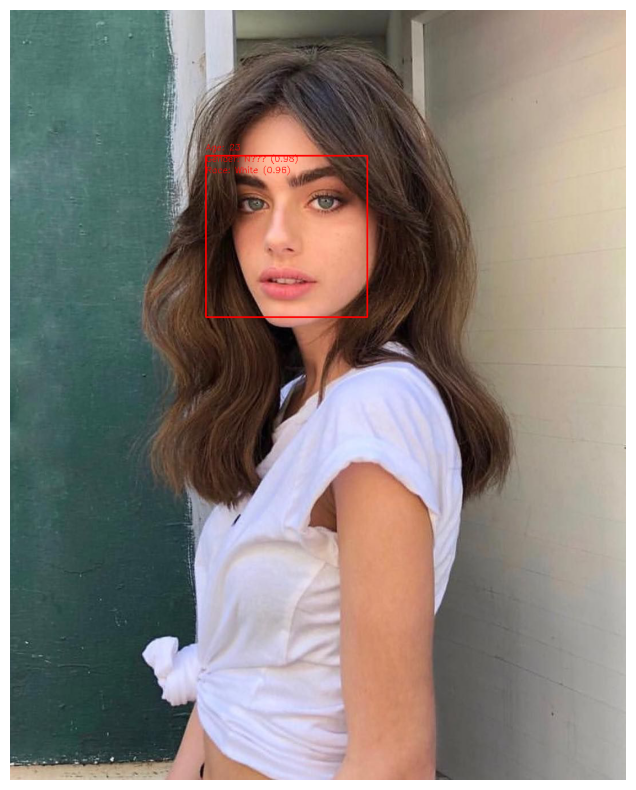

In [12]:
image_path = 'girl.jpg'

# Dự đoán
results = predict_demographics(image_path)

# Hiển thị kết quả
print("Kết quả nhận diện:")
print(f"Tuổi: {results['age']}")
print(f"Giới tính: {results['gender']} (độ tin cậy: {results['gender_confidence']:.2f})")
print(f"Sắc tộc: {results['race']} (độ tin cậy: {results['race_confidence']:.2f})")

# Hiển thị ảnh với kết quả
display_results(image_path, results)